In [27]:
import struct
from PIL import Image
import numpy as np

def read_record_ETL1G(f):
    s = f.read(2052)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_kana():
    katakana = np.zeros([51, 1411, 63, 64], dtype=np.uint8) 
    for i in range(7,14):
        filename = 'D:/ETL1/ETL1C_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            if i!=13: 
                limit = 8
            else:
                limit=3
            for dataset in range(limit):
                for j in range(1411):
                    try :
                        r = read_record_ETL1G(f)
                        katakana[(i - 7) * 8 + dataset, j] = np.array(r[-1])
                    except struct.error:
                        pass
    np.savez_compressed("kana.npz", katakana)

read_kana()

In [29]:
import skimage.transform
import numpy as np
from sklearn.model_selection import train_test_split

kana = np.load("kana.npz")['arr_0'].reshape([-1, 63, 64]).astype(np.float32)

kana = kana/np.max(kana)

katakana= 51
rows = 64
cols = 64


train_images_before = np.zeros([katakana * 1411, rows, cols], dtype=np.float32)


for i in range(katakana * 1411):
    train_images_before[i] = skimage.transform.resize(kana[i], (rows, cols))

arr = np.arange(katakana)
train_labels = np.repeat(arr, 1411)

for i in range(len(train_labels)):
	if train_labels[i] == 36:
		train_labels[i] = 1
	elif train_labels[i] == 38:
		train_labels[i] = 3
	elif train_labels[i] == 47:
		train_labels[i] = 2
	elif train_labels[i] == 37:
		train_labels[i] = train_labels[i] -1
	elif train_labels[i] >= 39 and train_labels[i] <= 46:
		train_labels[i] = train_labels[i] - 2
	elif train_labels[i] >= 48:
		train_labels[i] = train_labels[i] -3

delete = [] 
for i in range(len(train_images_before)):
	if (train_images_before[i] == np.zeros([train_images_before[i].shape[0],train_images_before[i].shape[1]],dtype=np.uint8) ).all():
		delete.append(i)

train_images_before = np.delete(train_images_before,delete[0],axis=0)
train_labels = np.delete(train_labels,delete[0])

train_images_before = np.delete(train_images_before,delete[1]-1,axis=0)
train_labels = np.delete(train_labels,delete[1]-1)

# split to train and test
train_images, test_images, train_labels, test_labels = train_test_split(train_images_before, train_labels, test_size=0.2)

np.savez_compressed("katakana_train_images.npz", train_images)
np.savez_compressed("katakana_train_labels.npz", train_labels)
np.savez_compressed("katakana_test_images.npz", test_images)
np.savez_compressed("katakana_test_labels.npz", test_labels)

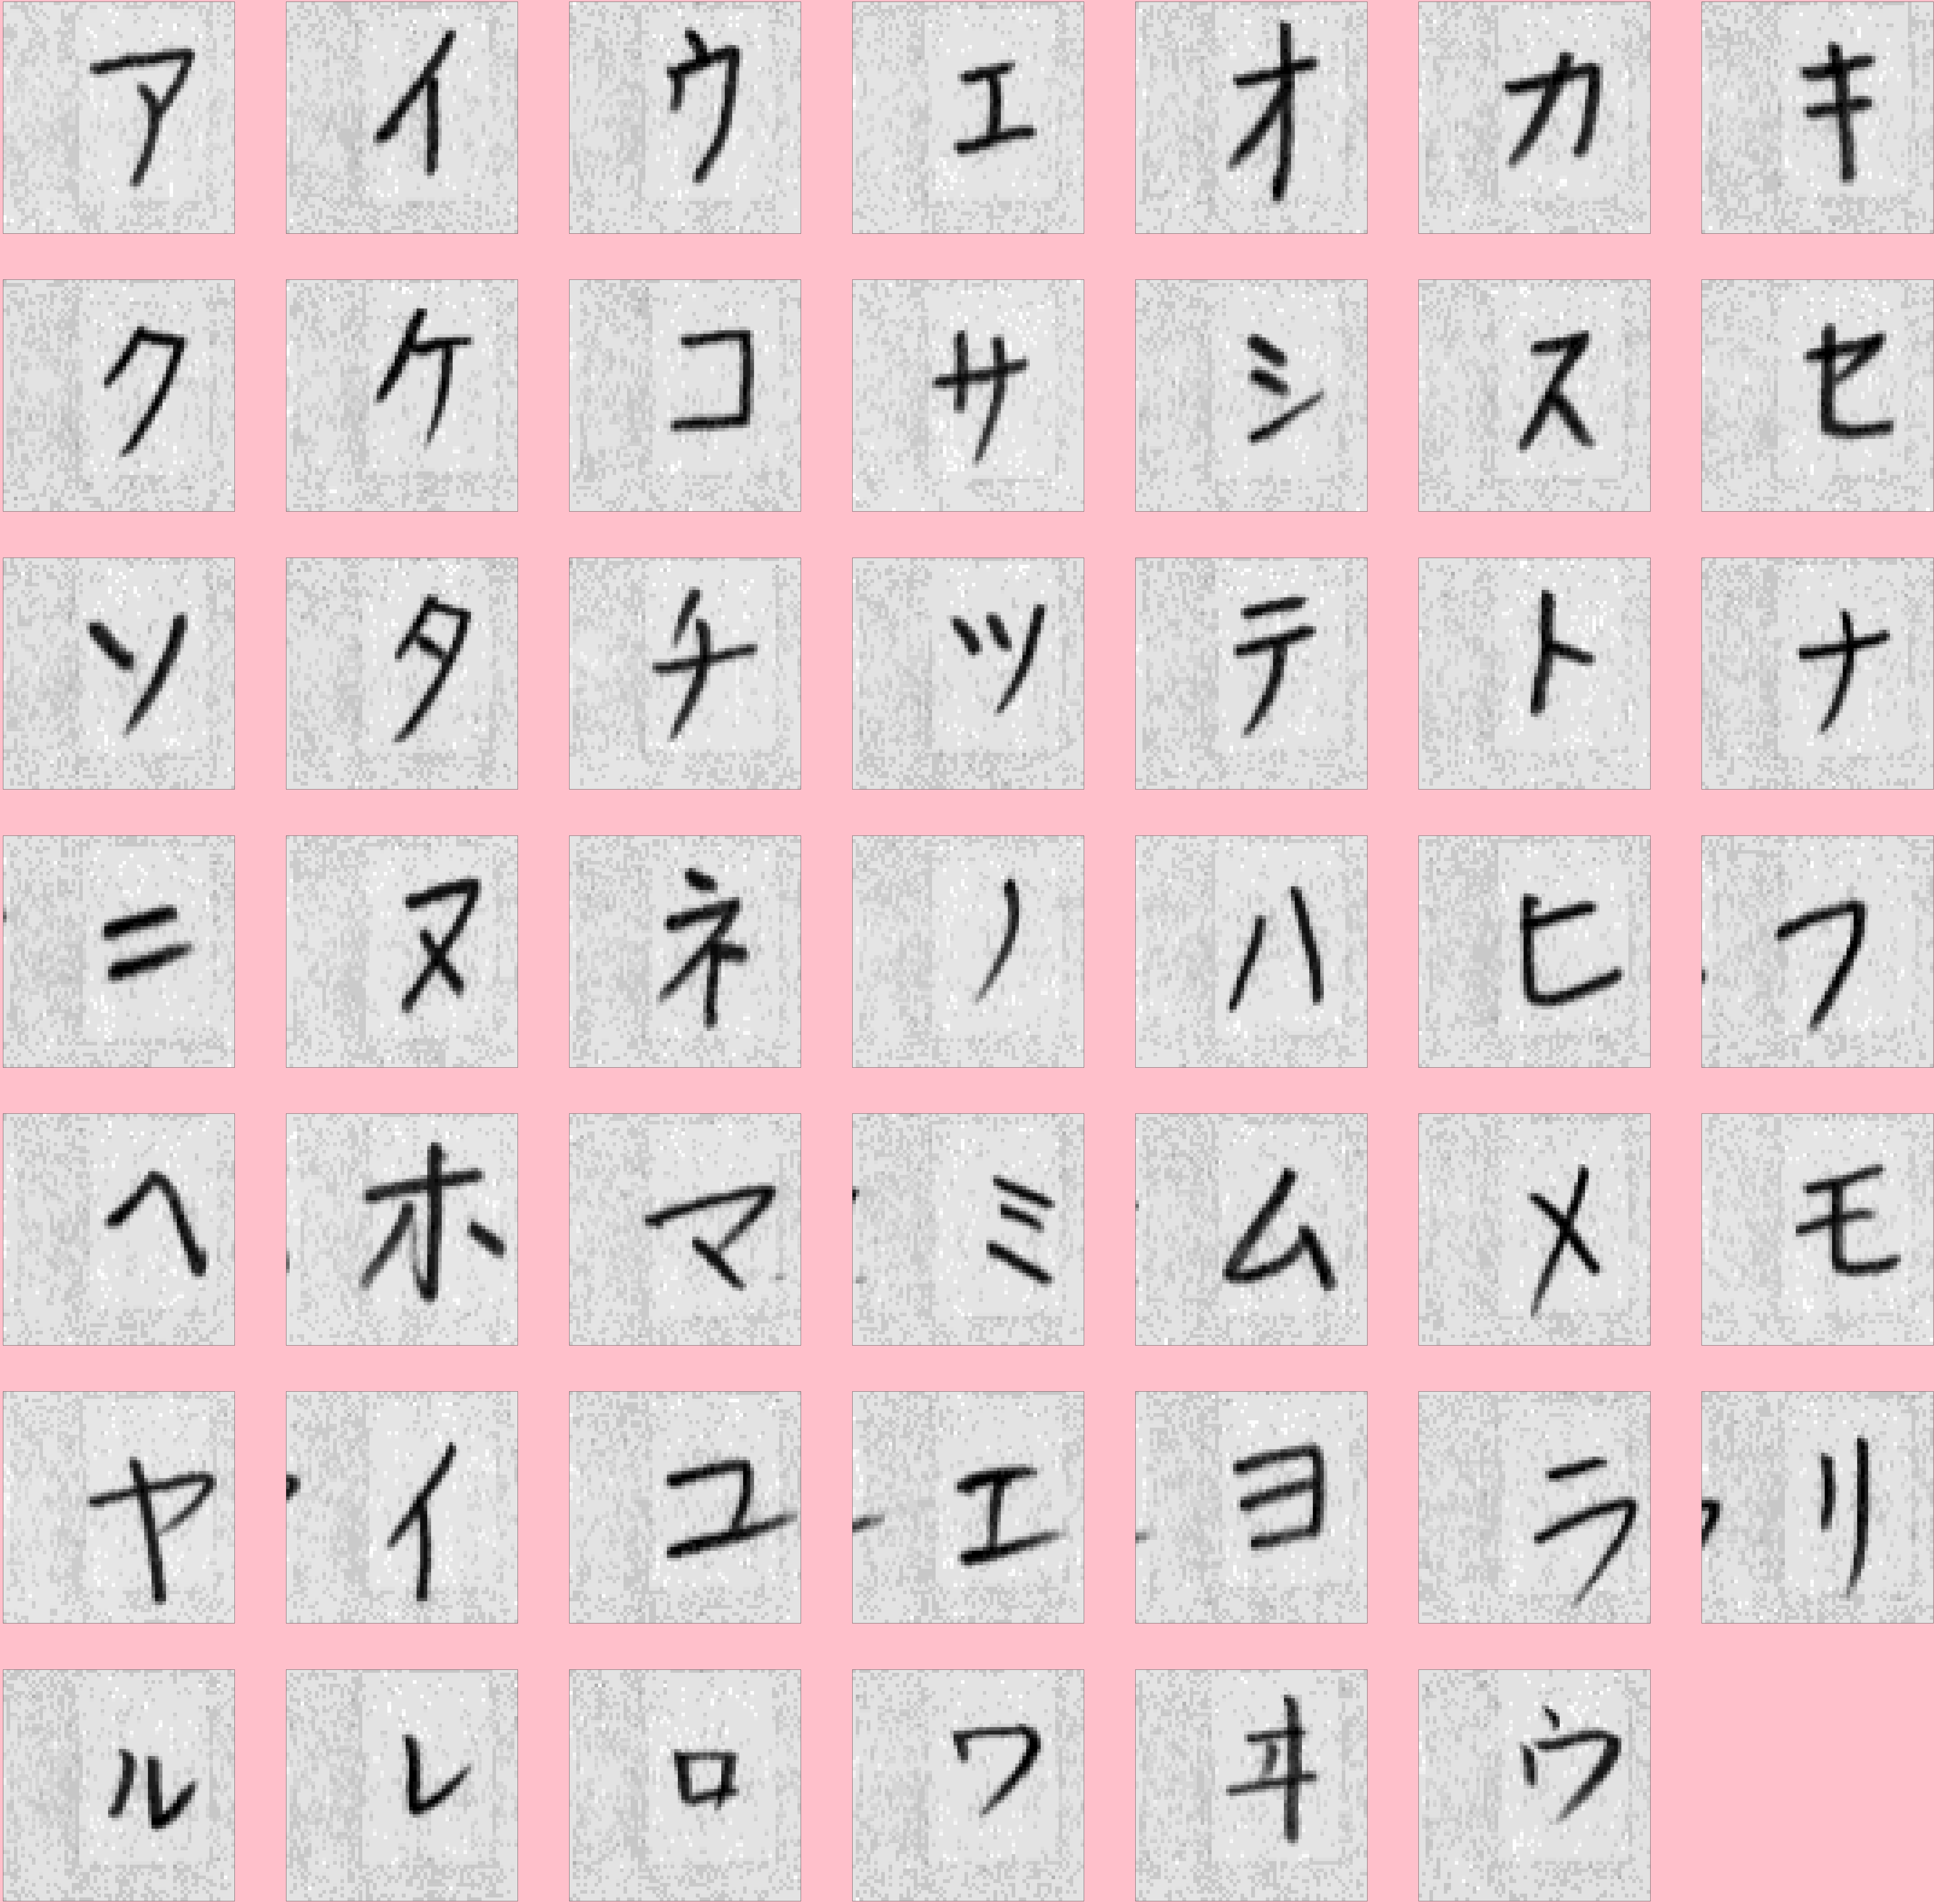

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(127,128)).patch.set_facecolor('pink')
for i in range(katakana-3):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_before[i*1411], cmap=plt.cm.binary)
plt.show()

In [31]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

train_images = np.load("katakana_train_images.npz")['arr_0']
train_labels = np.load("katakana_train_labels.npz")['arr_0']
test_images = np.load("katakana_test_images.npz")['arr_0']
test_labels = np.load("katakana_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images.shape[0], 1,64,64)
  test_images2 = test_images.reshape(test_images.shape[0], 1,64,64)
  shape = (1,64,64)
else:
  train_images = train_images.reshape(train_images.shape[0], 64, 64, 1)
  test_images2 = test_images.reshape(test_images.shape[0], 64, 64, 1)
  shape = (64,64,1)

datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.4)
datagen.fit(train_images)

model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(220, activation='relu'),
  keras.layers.Dense(48, activation="softmax")
])

model.summary()

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=40,validation_data=(test_images2,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

test_loss, test_acc = model.evaluate(test_images2, test_labels)
print("Test Accuracy: ", test_acc)

model.save("katakana.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

C:\Users\Pc\AppData\Local\Temp\ipykernel_8964\2831235172.py:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=40,validation_data=(test_images2,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])


1799/1799 [==============================] - 244s 135ms/step - loss: 1.0710 - accuracy: 0.7013 - val_loss: 0.2119 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 2/40
1799/1799 [==============================] - 242s 134ms/step - loss: 0.4162 - accuracy: 0.8782 - val_loss: 0.1600 - val_accuracy: 0.9621 - lr: 0.0010
Epoch 3/40
1799/1799 [==============================] - 242s 134ms/step - loss: 0.3290 - accuracy: 0.9066 - val_loss: 0.1423 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 4/40
1799/1799 [==============================] - 242s 134ms/step - loss: 0.2711 - accuracy: 0.9238 - val_loss: 0.1161 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 5/40
1799/1799 [==============================] - 242s 134ms/step - loss: 0.2447 - accuracy: 0.9316 - val_loss: 0.1122 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/40
1799/1799 [==============================] - 241s 134ms/step - loss: 0.2227 - accuracy: 0.9368 - val_loss: 0.1095 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 7/40
1799/1799 [=======================

In [3]:
import tensorflowjs as tfjs
from tensorflow import keras

model = keras.models.load_model("katakana.h5")   # for example
tfjs.converters.save_keras_model(model, "D:/BIAI-Project-2022.github.io/tfjs_file/katakana/")

In [14]:
import numpy as np
from tensorflow import keras

import skimage.transform as tr
from keras import backend as K


kana = np.load("kana.npz")['arr_0'].reshape([-1, 63, 64]).astype(np.float32)

kana = kana/np.max(kana)

finalData = []
whatMissed =[]

images_before = np.zeros([51* 1411, 64, 64], dtype=np.float32)


for i in range(51 * 1411):
    images_before[i] = tr.resize(kana[i], (64, 64))

arr = np.arange(51)
labels = np.repeat(arr, 1411)

for i in range(len(labels)):
	if labels[i] == 36:
		labels[i] = 1
	elif labels[i] == 38:
		labels[i] = 3
	elif labels[i] == 47:
		labels[i] = 2
	elif labels[i] == 37:
		labels[i] = labels[i] -1
	elif labels[i] >= 39 and labels[i] <= 46:
		labels[i] = labels[i] - 2
	elif labels[i] >= 48:
		labels[i] = labels[i] -3

delete = [] 
for i in range(len(images_before)):
	if (images_before[i] == np.zeros([images_before[i].shape[0],images_before[i].shape[1]],dtype=np.uint8) ).all():
		delete.append(i)

images_before = np.delete(images_before,delete[0],axis=0)
labels = np.delete(labels,delete[0])

images_before = np.delete(images_before,delete[1]-1,axis=0)
labels = np.delete(labels,delete[1]-1)

if K.image_data_format() == "channels_first":
	images_before = images_before.reshape(images_before.shape[0], 1,64,64)
else:
	images_before = images_before.reshape(images_before.shape[0], 64, 64, 1)

model = keras.models.load_model("katakana.h5") 
output = model.predict(images_before)

images_after = np.argmax(output,axis=1)

print()
for i in range(len(images_after)):
	if(labels[i]!= images_after[i]):
		print(": [",labels[i], ": ", images_after[i],"]")
		finalData.append((labels[i],images_after[i]))
		whatMissed.append(labels[i])

missedCount = []
for h in range(48):
	missedCount.append((h,whatMissed.count(h)))

missedCount.sort(reverse=True, key=lambda e: e[1])
for h in range(48):
	print(missedCount[h])

2249/2249 [==============================] - 70s 30ms/step

: [ 0 :  30 ]
: [ 0 :  45 ]
: [ 0 :  30 ]
: [ 0 :  35 ]
: [ 0 :  35 ]
: [ 0 :  18 ]
: [ 0 :  30 ]
: [ 0 :  30 ]
: [ 0 :  30 ]
: [ 0 :  10 ]
: [ 0 :  30 ]
: [ 1 :  14 ]
: [ 1 :  30 ]
: [ 1 :  30 ]
: [ 1 :  20 ]
: [ 1 :  11 ]
: [ 1 :  12 ]
: [ 2 :  43 ]
: [ 2 :  38 ]
: [ 2 :  12 ]
: [ 2 :  43 ]
: [ 3 :  45 ]
: [ 3 :  34 ]
: [ 3 :  31 ]
: [ 3 :  34 ]
: [ 3 :  45 ]
: [ 3 :  45 ]
: [ 3 :  45 ]
: [ 3 :  45 ]
: [ 3 :  13 ]
: [ 3 :  45 ]
: [ 4 :  14 ]
: [ 5 :  27 ]
: [ 5 :  15 ]
: [ 6 :  16 ]
: [ 6 :  16 ]
: [ 6 :  16 ]
: [ 7 :  2 ]
: [ 7 :  43 ]
: [ 7 :  5 ]
: [ 7 :  27 ]
: [ 7 :  43 ]
: [ 7 :  27 ]
: [ 7 :  43 ]
: [ 7 :  20 ]
: [ 7 :  27 ]
: [ 7 :  43 ]
: [ 7 :  43 ]
: [ 7 :  43 ]
: [ 7 :  27 ]
: [ 7 :  17 ]
: [ 7 :  43 ]
: [ 7 :  43 ]
: [ 7 :  43 ]
: [ 7 :  24 ]
: [ 7 :  43 ]
: [ 7 :  43 ]
: [ 7 :  43 ]
: [ 8 :  7 ]
: [ 8 :  10 ]
: [ 8 :  10 ]
: [ 8 :  2 ]
: [ 8 :  10 ]
: [ 8 :  19 ]
: [ 8 :  18 ]
: [ 8 :  7 ]
: [ 9 :  36 ]
: [ 9 :

In [ ]:
import numpy as np
from tensorflow import keras
from katanaList import label
import skimage.transform as tr
from keras import backend as K


kana = np.load("kana.npz")['arr_0'].reshape([-1, 63, 64]).astype(np.float32)

kana = kana/np.max(kana)

finalData = []
whatMissed =[]

images_before = np.zeros([51* 1411, 64, 64], dtype=np.float32)


for i in range(51 * 1411):
    images_before[i] = tr.resize(kana[i], (64, 64))

arr = np.arange(51)
labels = np.repeat(arr, 1411)

for i in range(len(labels)):
	if labels[i] == 36:
		labels[i] = 1
	elif labels[i] == 38:
		labels[i] = 3
	elif labels[i] == 47:
		labels[i] = 2
	elif labels[i] == 37:
		labels[i] = labels[i] -1
	elif labels[i] >= 39 and labels[i] <= 46:
		labels[i] = labels[i] - 2
	elif labels[i] >= 48:
		labels[i] = labels[i] -3

delete = [] 
for i in range(len(images_before)):
	if (images_before[i] == np.zeros([images_before[i].shape[0],images_before[i].shape[1]],dtype=np.uint8) ).all():
		delete.append(i)

images_before = np.delete(images_before,delete[0],axis=0)
labels = np.delete(labels,delete[0])

images_before = np.delete(images_before,delete[1]-1,axis=0)
labels = np.delete(labels,delete[1]-1)

if K.image_data_format() == "channels_first":
	images_before = images_before.reshape(images_before.shape[0], 1,64,64)
else:
	images_before = images_before.reshape(images_before.shape[0], 64, 64, 1)

model = keras.models.load_model("katakana.h5") 
output = model.predict(images_before)

images_after = np.argmax(output,axis=1)

print()
for i in range(len(images_after)):
	if(labels[i]!= images_after[i]):
		print(": [",labels[i], ": ", images_after[i],"]")
		finalData.append((labels[i],images_after[i]))
		whatMissed.append(labels[i])

missedCount = []
for h in range(48):
	missedCount.append((h,whatMissed.count(h)))

missedCount.sort(reverse=True, key=lambda e: e[1])
for h in range(48):
	print(missedCount[h])

fin = []
for i in range(5):
    fin.append([child for parent, child in finalData if parent == missedCount[i][0]]) 
    final = fin[i]
    fin[i] = list(set([(label[t], final.count(t)) for t in final]))
    fin[i].sort(reverse=True, key=lambda e: e[1])
